# Summary of the experiments

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import os

from multiprocessing import Pool

In [2]:
sns.set_style('whitegrid')

### Adaptive FEDD - feature weight distribution

In [3]:
metadata_initial = pd.read_csv('../data/interim/2024_04_11_artificial_data/feature_metadata.csv', index_col=0)
metadata_initial.columns = ['features', 'weight', 'true_positives', 'false_positives', 'n_truth', 'n_detected']

In [4]:
metadata_artificial = pd.read_csv('../data/processed/2024_07_04_artificial_data/feature_metadata.csv', index_col=0)
metadata_real = pd.read_csv('../data/processed/2024_06_10_real_data/feature_metadata.csv', index_col=0)

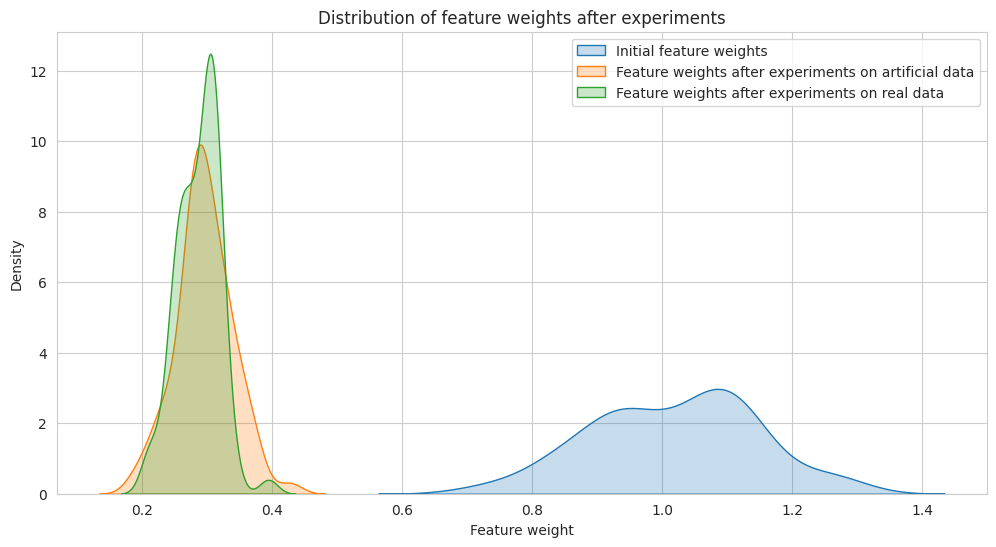

In [6]:
plt.subplots(figsize=(12, 6))

sns.kdeplot(metadata_initial['weight'], label='Initial feature weights', fill=True)
sns.kdeplot(metadata_artificial['weight'], label='Feature weights after experiments on artificial data', fill=True)
sns.kdeplot(metadata_real['weight'], label='Feature weights after experiments on real data', fill=True)

plt.title('Distribution of feature weights after experiments')
plt.xlabel('Feature weight')
plt.legend()

plt.show()

### Load data

In [7]:
from river import compose

def get_daily_dummies(x):
    return {}

def get_hourly_dummies(x):
   return {}

def get_daily_dummies_timestamp(x):
    return {}

def get_hour_dummies_timestamp(x):
    return {}

In [8]:
def load_pickle_file(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [9]:
def load_results(path_with_saved_results):
    results = {}

    time_series = [q for q in os.listdir(path_with_saved_results) if not '.csv' in q]

    for ts in time_series:
        experimets = os.listdir(os.path.join(path_with_saved_results, ts))

        ts_dict = {}
        for experiment in experimets:
            try:
                ts_dict[experiment.replace('.pickle', '')] = load_pickle_file(os.path.join(path_with_saved_results, ts, experiment))
            except Exception as e:
                print(f'Error while loading {ts}/{experiment}: {e}')
                continue

        results[ts] = ts_dict
    
    return results

In [10]:
def artificial_data_type(ts_name):
    if 'linear_seasonal' in ts_name:
        key = 'linear_seasonal'
    elif 'nonlinear' in ts_name:
        key = 'nonlinear'
    elif 'linear' in ts_name:
        key = 'linear'
    return key

In [11]:
def artificial_data_type_pretty(ts_name):
    if 'linear_seasonal' in ts_name:
        key = 'Linear seasonal'
    elif 'nonlinear' in ts_name:
        key = 'Nonlinear'
    elif 'linear' in ts_name:
        key = 'Linear'
    return key

In [12]:
def real_data_type(ts_name):
    if 'memory' in ts_name:
        key = 'Memory percentage usage'
    elif 'cpu' in ts_name:
        key = 'CPU percentage usage'
    return key

In [13]:
results_artificial = load_results('../data/processed/2024_07_04_artificial_data')

In [14]:
results_real = load_results('../data/processed/2024_06_10_real_data')

### Count the number of detections and replacements in artificial data

In [15]:
def count_detections_and_replacements(results, filter_func, ts_name_agg=artificial_data_type):
    if_replaced_buckets = {}

    for ts_name, exp_dict in results.items():
        key = ts_name_agg(ts_name)

        detected = 0
        actually_replaced = 0
        n = 0

        for exp_name, exp_obj in exp_dict.items():
            if 'batch' in exp_name and 'adaptive_fedd' in exp_name:
                if filter_func(exp_name):
                    detected += len(exp_obj['experiment_obj'].replacement_history)
                    actually_replaced += sum(exp_obj['experiment_obj'].was_replaced_history)
                    n += 1
        
        if key in if_replaced_buckets.keys():
            if_replaced_buckets[key][0] += detected
            if_replaced_buckets[key][1] += actually_replaced
            if_replaced_buckets[key][2] += n
        else:
            if_replaced_buckets[key] = [detected, actually_replaced, n]
    
    processed_if_replaced_buckets = []
    for key, res_list in if_replaced_buckets.items():
        processed_if_replaced_buckets.append({
            'Time series type': key,
            'count_type': 'Detected drifts',
            'Mean count': res_list[0] / res_list[2]
        })

        processed_if_replaced_buckets.append({
            'Time series type': key,
            'count_type': 'Model replacements',
            'Mean count': res_list[1] / res_list[2]
        })
        
    return pd.DataFrame(processed_if_replaced_buckets)

In [16]:
counted_detections_and_replacements_artificial = count_detections_and_replacements(results_artificial, filter_func=lambda x: 'without_weight_sharing' in x)
counted_detections_and_replacements_artificial_sharing_weights = count_detections_and_replacements(results_artificial, filter_func=lambda x: 'without' not in x)
counted_detections_and_replacements_artificial_distance_weights = count_detections_and_replacements(results_artificial, filter_func=lambda x: 'with_weight_in_distance' in x)
counted_detections_and_replacements_artificial_without_initial = count_detections_and_replacements(results_artificial, filter_func=lambda x: 'without_initial' in x)

In [17]:
counted_detections_and_replacements_artificial['Time series type'] = counted_detections_and_replacements_artificial['Time series type'].apply(artificial_data_type_pretty)
counted_detections_and_replacements_artificial_sharing_weights['Time series type'] = counted_detections_and_replacements_artificial_sharing_weights['Time series type'].apply(artificial_data_type_pretty)
counted_detections_and_replacements_artificial_distance_weights['Time series type'] = counted_detections_and_replacements_artificial_distance_weights['Time series type'].apply(artificial_data_type_pretty)
counted_detections_and_replacements_artificial_without_initial['Time series type'] = counted_detections_and_replacements_artificial_without_initial['Time series type'].apply(artificial_data_type_pretty)

In [18]:
counted_detections_and_replacements_artificial_sharing_weights['Time series type'] += ' with online\nweight sharing'
counted_detections_and_replacements_artificial_distance_weights['Time series type'] += ' with weights\nin distance function'
counted_detections_and_replacements_artificial_without_initial['Time series type'] += ' without\ninitial weights'

In [19]:
dfs_counts_artificial = [
    counted_detections_and_replacements_artificial, counted_detections_and_replacements_artificial_sharing_weights, 
    counted_detections_and_replacements_artificial_distance_weights, counted_detections_and_replacements_artificial_without_initial
]

In [20]:
df_to_visualise = pd.concat(dfs_counts_artificial).reset_index(drop=True)

order = np.zeros(df_to_visualise.shape[0])
k = 0
for i in range(3):
    base = 2 * i
    for j in range(4):
        order[k] = base + 6*j
        k += 1
        order[k] = base + 6*j + 1
        k += 1

df_to_visualise = df_to_visualise.loc[order].copy()

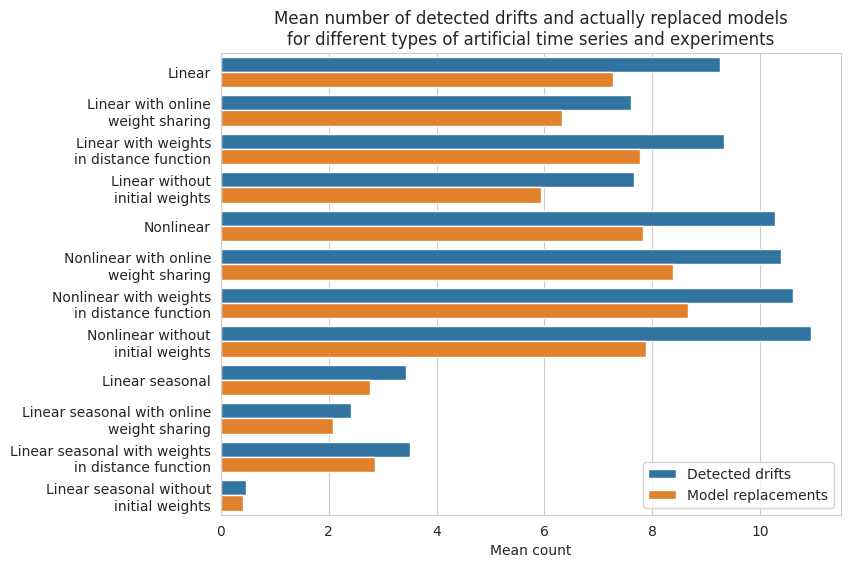

In [22]:
plt.subplots(figsize=(8, 6))
sns.barplot(y='Time series type', x='Mean count', hue='count_type', data=df_to_visualise)
plt.title('Mean number of detected drifts and actually replaced models\nfor different types of artificial time series and experiments')
plt.gca().legend(title='')
plt.ylabel('')
plt.show()

### Count the number of detections and replacements in real data

In [23]:
counted_detections_and_replacements_real = count_detections_and_replacements(results_real, filter_func=lambda x: 'without_weight_sharing' in x, ts_name_agg=real_data_type)
counted_detections_and_replacements_real_sharing_weights = count_detections_and_replacements(results_real, filter_func=lambda x: 'without' not in x, ts_name_agg=real_data_type)
counted_detections_and_replacements_real_distance_weights = count_detections_and_replacements(results_real, filter_func=lambda x: 'with_weight_in_distance' in x, ts_name_agg=real_data_type)
counted_detections_and_replacements_real_without_initial = count_detections_and_replacements(results_real, filter_func=lambda x: 'without_initial' in x, ts_name_agg=real_data_type)

In [24]:
counted_detections_and_replacements_real_sharing_weights['Time series type'] += '\nwith online weight sharing'
counted_detections_and_replacements_real_distance_weights['Time series type'] += '\nwith weights in distance function'
counted_detections_and_replacements_real_without_initial['Time series type'] += '\nwithout initial weights'

In [25]:
dfs_counts_real = [
    counted_detections_and_replacements_real, counted_detections_and_replacements_real_sharing_weights, 
    counted_detections_and_replacements_real_distance_weights, counted_detections_and_replacements_real_without_initial
]

In [26]:
df_to_visualise = pd.concat(dfs_counts_real).reset_index(drop=True)

order = np.zeros(df_to_visualise.shape[0])
k = 0
for i in range(2):
    base = 2 * i
    for j in range(4):
        order[k] = base + 4*j
        k += 1
        order[k] = base + 4*j + 1
        k += 1

df_to_visualise = df_to_visualise.loc[order].copy()

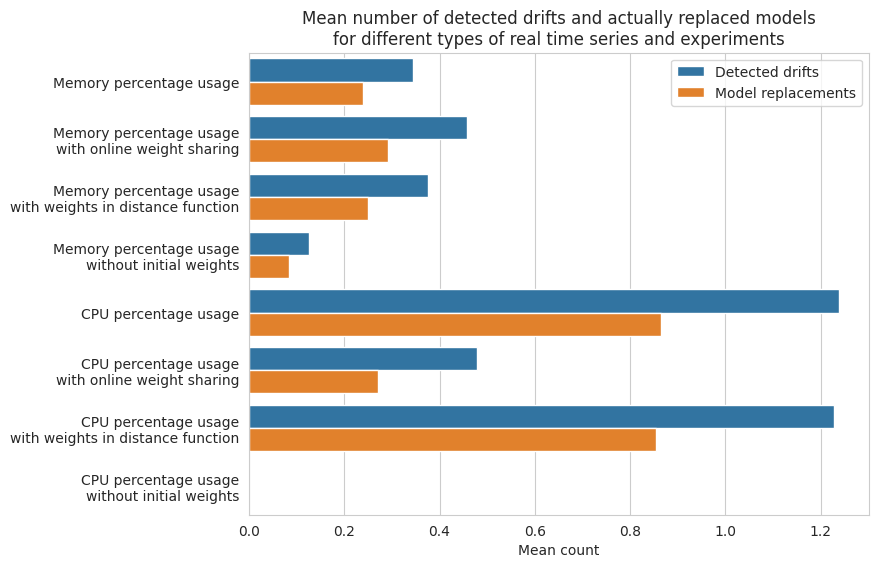

In [28]:
plt.subplots(figsize=(8, 6))
sns.barplot(y='Time series type', x='Mean count', hue='count_type', data=df_to_visualise)
plt.title('Mean number of detected drifts and actually replaced models\nfor different types of real time series and experiments')
plt.gca().legend(title='')
plt.ylabel('')
plt.show()

### Tables with aggregated results

In [29]:
from sklearn.metrics import root_mean_squared_error as rmse

In [30]:
def calculate_metric_per_origin(y_true, y_hat, metric=rmse):
    out = []
    origins = np.unique(y_hat['origin'])

    for origin in origins:
        horizon = y_hat[y_hat['origin'] == origin]['timestamp'].tolist()
        y_true_horizon = y_true[y_true['timestamp'].isin(horizon)]['value'].to_numpy()
        y_hat_horizon = y_hat[y_hat['origin'] == origin]['value'].to_numpy()

        if len(y_true_horizon) < len(y_hat_horizon):
            # case at the end of the time
            continue

        val = metric(y_true_horizon, y_hat_horizon)
        out.append({
            'origin': origin,
            'metric': val
        })
        
    return pd.DataFrame(out)

In [31]:
def calculate_rmse_mean_for_time_series(ts, experiment, path_to_pickle):
    ts_name = ts
    exp_obj = load_pickle_file(path_to_pickle)

    obj = exp_obj['experiment_obj']
    rmse_df = calculate_metric_per_origin(obj.data, obj.predictions)
    rmse_mean = np.mean(rmse_df['metric'])

    return ts, experiment, rmse_mean

In [32]:
def generate_params_per_folder(path_with_saved_results):
    time_series = [q for q in os.listdir(path_with_saved_results) if not '.csv' in q]
    paths = []

    for ts in time_series:
        experimets = os.listdir(os.path.join(path_with_saved_results, ts))

        for experiment in experimets:
            path_to_pickle = os.path.join(path_with_saved_results, ts, experiment)

            paths.append((ts, experiment, path_to_pickle))
            
    return paths

In [33]:
# with Pool(8) as pool:
#     path_with_saved_results = '../data/processed/2024_06_10_real_data'
#     params = generate_params_per_folder(path_with_saved_results)
#     rmse_per_experiment_real = pool.starmap(calculate_rmse_mean_for_time_series, params)

# with open('./cache_rmse_real.pickle', 'wb') as f:
#     pickle.dump(rmse_per_experiment_real, f)

In [34]:
# with Pool(8) as pool:
#     path_with_saved_results = '../data/processed/2024_05_26_artificial_data'
#     params = generate_params_per_folder(path_with_saved_results)
#     rmse_per_experiment_artificial = pool.starmap(calculate_rmse_mean_for_time_series, params)

# with open('./cache_rmse_artificial.pickle', 'wb') as f:
#     pickle.dump(rmse_per_experiment_artificial, f)

In [35]:
with open('./cache_rmse_real.pickle', 'rb') as f:
    rmse_per_experiment_real = pickle.load(f)

with open('./cache_rmse_artificial.pickle', 'rb') as f:
    rmse_per_experiment_artificial = pickle.load(f)

General table for artificial

In [37]:
def exp_name_to_framework(exp_name):
    if exp_name.startswith('online'):
        return 'Online'
    if exp_name.startswith('batch') and 'adaptive_fedd' in exp_name:
        return 'Advanced Batch'
    if exp_name.startswith('batch') and 'adaptive_fedd' not in exp_name:
        return 'Simple Batch'

In [38]:
def exp_name_to_drift_detector(exp_name):
    if 'no_drift' in exp_name:
        return '-'
    
    if 'adaptive_fedd' in exp_name:
        if 'without_initial_weights' in exp_name:
            return 'Adaptive FEDD without initial weights'
        elif 'without_weight_sharing_with_weight_in_distance' in exp_name:
            return 'Adaptive FEDD with weights in distance'
        elif 'without_weight_sharing' in exp_name:
            return 'Adaptive FEDD'
        else:
            return 'Adaptive FEDD with online weight sharing'
    
    if 'fedd' in exp_name:
        return 'FEDD'
    if 'kswin' in exp_name:
        return 'KSWIN'
    if 'adwin' in exp_name:
        return 'ADWIN'
    
    if 'online' in exp_name:
        if 'arf' in exp_name:
            return 'ADWIN'
        else:
            return '-'

In [39]:
def exp_name_to_model(exp_name):
    if 'online__arx' in exp_name:
        return 'Online ARX'
    if 'arx' in exp_name:
        return 'ARX'
    if 'lightgbm' in exp_name:
        return 'LightGBM'
    if 'arf' in exp_name:
        return 'Adaptive Random Forest'
    if 'rf' in exp_name:
        return 'Random Forest'

In [40]:
ranks = {
    'Simple Batch': 0,
    'Advanced Batch': 1,
    'Online': 2,
    'Modified Adaptive Random Forest': 3,
}

ranks_detectors = {
    '-': 0,
    'ADWIN': 1,
    'FEDD': 2,
    'KSWIN': 3,
    'Adaptive FEDD': 4,
    'Adaptive FEDD with weights in distance': 5,
    'Adaptive FEDD with online weight sharing': 6,
    'Adaptive FEDD without initial weights': 7,
}

In [41]:
df_after_exp = pd.DataFrame(rmse_per_experiment_artificial).iloc[:, 0:-1]
df_after_exp.columns = ['ts', 'exp', 'rmse']
df_after_exp['ts'] = df_after_exp['ts'].apply(artificial_data_type_pretty)

df_after_exp['exp'] = df_after_exp['exp'].str.split('.').str[0]
df_after_exp['framework'] = df_after_exp['exp'].apply(exp_name_to_framework)
df_after_exp['detector'] = df_after_exp['exp'].apply(exp_name_to_drift_detector)
df_after_exp['model'] = df_after_exp['exp'].apply(exp_name_to_model)

df_after_exp = df_after_exp.groupby(['ts', 'framework', 'detector', 'model'])['rmse'].mean().reset_index()
df_after_exp = pd.pivot(df_after_exp, columns='ts', index=['framework', 'detector', 'model']).reset_index()

df_after_exp.columns = df_after_exp.columns.droplevel(0)
df_after_exp.columns.name = None
cols = list(df_after_exp.columns)
cols[0] = 'Framework'
cols[1] = 'Detector'
cols[2] = 'Model'
df_after_exp.columns = cols

for i in range(df_after_exp.shape[0]):
    if df_after_exp.loc[i]['Framework'] == 'Online' and \
       df_after_exp.loc[i]['Model'] == 'Adaptive Random Forest' and \
       df_after_exp.loc[i]['Detector'] != 'ADWIN':
        df_after_exp.loc[i, 'Framework'] = 'Modified Adaptive Random Forest'
        df_after_exp.loc[i, 'Model'] = 'Modified Adaptive Random Forest'

df_after_exp['frm_rank'] = df_after_exp['Framework'].map(ranks).reset_index(drop=True)
df_after_exp['dt_rank'] = df_after_exp['Detector'].map(ranks_detectors).reset_index(drop=True)

df_after_exp = df_after_exp.sort_values(by=['frm_rank', 'dt_rank'], ascending=[True, True]).iloc[:, :-2].reset_index(drop=True).copy()

df_after_exp

,Framework,Detector,Model,Linear,Linear seasonal,Nonlinear
0,Simple Batch,-,ARX,192.612974,14.943795,85.790109
1,Simple Batch,-,LightGBM,341.275844,12.500173,102.821198
2,Simple Batch,-,Random Forest,341.788866,12.244442,102.693322
3,Simple Batch,ADWIN,ARX,14.570533,3.459436,18.571460
4,Simple Batch,ADWIN,LightGBM,28.313492,4.601300,25.556823
5,Simple Batch,ADWIN,Random Forest,28.010902,4.861624,25.073141
6,Simple Batch,FEDD,ARX,110.124589,4.153141,30.983294
7,Simple Batch,FEDD,LightGBM,240.497731,5.073680,78.152769
8,Simple Batch,FEDD,Random Forest,240.364103,5.200809,77.890358
9,Simple Batch,KSWIN,ARX,16.940715,3.635919,18.646592


General table for real

In [43]:
df_after_exp = pd.DataFrame(rmse_per_experiment_real).iloc[:, 0:-1]
df_after_exp.columns = ['ts', 'exp', 'rmse']
df_after_exp['ts'] = df_after_exp['ts'].apply(real_data_type)

df_after_exp['exp'] = df_after_exp['exp'].str.split('.').str[0]
df_after_exp['framework'] = df_after_exp['exp'].apply(exp_name_to_framework)
df_after_exp['detector'] = df_after_exp['exp'].apply(exp_name_to_drift_detector)
df_after_exp['model'] = df_after_exp['exp'].apply(exp_name_to_model)

df_after_exp = df_after_exp.groupby(['ts', 'framework', 'detector', 'model'])['rmse'].mean().reset_index()
df_after_exp = pd.pivot(df_after_exp, columns='ts', index=['framework', 'detector', 'model']).reset_index()

df_after_exp.columns = df_after_exp.columns.droplevel(0)
df_after_exp.columns.name = None
cols = list(df_after_exp.columns)
cols[0] = 'Framework'
cols[1] = 'Detector'
cols[2] = 'Model'
df_after_exp.columns = cols

for i in range(df_after_exp.shape[0]):
    if df_after_exp.loc[i]['Framework'] == 'Online' and \
       df_after_exp.loc[i]['Model'] == 'Adaptive Random Forest' and \
       df_after_exp.loc[i]['Detector'] != 'ADWIN':
        df_after_exp.loc[i, 'Framework'] = 'Modified Adaptive Random Forest'
        df_after_exp.loc[i, 'Model'] = 'Modified Adaptive Random Forest'

df_after_exp['frm_rank'] = df_after_exp['Framework'].map(ranks)
df_after_exp['dt_rank'] = df_after_exp['Detector'].map(ranks_detectors).reset_index(drop=True)

df_after_exp = df_after_exp.sort_values(by=['frm_rank', 'dt_rank'], ascending=[True, True]).iloc[:, :-2].reset_index(drop=True).copy()

df_after_exp

,Framework,Detector,Model,CPU percentage usage,Memory percentage usage
0,Simple Batch,-,ARX,1.254655,8.006153
1,Simple Batch,-,LightGBM,1.360676,12.540734
2,Simple Batch,-,Random Forest,1.218829,9.914012
3,Simple Batch,ADWIN,ARX,2.009194,7.322479
4,Simple Batch,ADWIN,LightGBM,1.243596,10.012763
5,Simple Batch,ADWIN,Random Forest,1.099133,8.310223
6,Simple Batch,FEDD,ARX,1.295459,7.258264
7,Simple Batch,FEDD,LightGBM,1.235022,10.165719
8,Simple Batch,FEDD,Random Forest,1.091495,8.162855
9,Simple Batch,KSWIN,ARX,1.477474,7.424307


### Mean number of drift detections for each method

In [45]:
def count_detections(results, ts_name_agg=artificial_data_type, exp_name_agg=exp_name_to_drift_detector):
    if_replaced_buckets = {}

    for ts_name, exp_dict in results.items():
        key = ts_name_agg(ts_name)

        for exp_name, exp_obj in exp_dict.items():
            if 'batch' in exp_name:
                exp_key = exp_name_agg(exp_name)
                detected = len(exp_obj['experiment_obj'].replacement_history)
                n = 1
        
                if (key, exp_key) in if_replaced_buckets.keys():
                    if_replaced_buckets[(key, exp_key)][0] += detected
                    if_replaced_buckets[(key, exp_key)][1] += n
                else:
                    if_replaced_buckets[(key, exp_key)] = [detected, n]
    
    processed_if_replaced_buckets = []
    for key, res_list in if_replaced_buckets.items():
        processed_if_replaced_buckets.append({
            'Time series type': key[0],
            'Detector type': key[1],
            'Mean count': res_list[0] / res_list[1]
        })
        
    return pd.DataFrame(processed_if_replaced_buckets)

In [46]:
detections_per_method_artificial = count_detections(results_artificial, artificial_data_type_pretty)
detections_per_method_real = count_detections(results_real, real_data_type)

In [47]:
df_detections_per_method_artificial = pd.pivot(
    detections_per_method_artificial, columns='Time series type', index='Detector type'
).reset_index()

df_detections_per_method_artificial.columns = df_detections_per_method_artificial.columns.droplevel(0)
df_detections_per_method_artificial.columns.name = None
cols = list(df_detections_per_method_artificial.columns)
cols[0] = 'Detector'
df_detections_per_method_artificial.columns = cols
df_detections_per_method_artificial = df_detections_per_method_artificial[df_detections_per_method_artificial['Detector'] != '-']

df_detections_per_method_artificial['dt_rank'] = df_detections_per_method_artificial['Detector'].map(ranks_detectors)
df_detections_per_method_artificial = df_detections_per_method_artificial.sort_values(by='dt_rank', ascending=True).iloc[:, :-1].reset_index(drop=True).copy()

df_detections_per_method_artificial

,Detector,Linear,Linear seasonal,Nonlinear
0,ADWIN,52.166667,50.083333,50.500000
1,FEDD,9.833333,31.250000,25.833333
2,KSWIN,31.500000,20.416667,31.666667
3,Adaptive FEDD,9.166667,3.361111,9.944444
4,Adaptive FEDD with weights in distance,9.333333,3.500000,10.611111
5,Adaptive FEDD with online weight sharing,7.611111,2.416667,10.388889
6,Adaptive FEDD without initial weights,7.666667,0.472222,10.944444


In [49]:
df_detections_per_method_real = pd.pivot(
    detections_per_method_real, columns='Time series type', index='Detector type'
).reset_index()
df_detections_per_method_real.columns = df_detections_per_method_real.columns.droplevel(0)
df_detections_per_method_real.columns.name = None
cols = list(df_detections_per_method_real.columns)
cols[0] = 'Detector'
df_detections_per_method_real.columns = cols
df_detections_per_method_real = df_detections_per_method_real[df_detections_per_method_real['Detector'] != '-']

df_detections_per_method_real['dt_rank'] = df_detections_per_method_real['Detector'].map(ranks_detectors)
df_detections_per_method_real = df_detections_per_method_real.sort_values(by='dt_rank', ascending=True).iloc[:, :-1].reset_index(drop=True).copy()

df_detections_per_method_real

,Detector,CPU percentage usage,Memory percentage usage
0,ADWIN,11.000000,12.812500
1,FEDD,10.500000,9.437500
2,KSWIN,5.562500,7.437500
3,Adaptive FEDD,1.250000,0.312500
4,Adaptive FEDD with weights in distance,1.229167,0.375000
5,Adaptive FEDD with online weight sharing,0.479167,0.458333
6,Adaptive FEDD without initial weights,0.000000,0.125000


### Statistical tests

In [51]:
from scipy.stats import friedmanchisquare as friedman
from scikit_posthocs import posthoc_nemenyi_friedman
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

In [52]:
def generate_key_per_stat_test(name):
    detector = exp_name_to_drift_detector(name)
    framework = exp_name_to_framework(name)
    model = exp_name_to_model(name)

    framework_translate = {
        'Simple Batch': 'SB',
        'Advanced Batch': 'AB',
        'Online': 'ON'
    }

    def detector_translate(detector):
        if detector == 'Adaptive FEDD':
            return 'A_FEDD'
        if detector == 'Adaptive FEDD with weights in distance':
            return 'A_FEDD_W'
        if detector == 'Adaptive FEDD with online weight sharing':
            return 'A_FEDD_OW'
        if detector == 'Adaptive FEDD without initial weights':
            return 'A_FEDD_NW'
        if detector == '-':
            return 'ND'
        return detector
    
    def model_translate(model):
        if model == 'Online ARX':
            return 'O_ARX'
        if model == 'Adaptive Random Forest':
            return 'ARF'
        if model == 'LightGBM':
            return 'LGBM'
        if model == 'Random Forest':
            return 'RF'
        return model.upper()
        
    return f"{framework_translate[framework]}--{model_translate(model)}--{detector_translate(detector)}"

In [53]:
def run_tests(df):
    data = np.array(df)
    friedman_result = friedman(*data.T)
    post_hoc_results = posthoc_nemenyi_friedman(data)

    return friedman_result, post_hoc_results

In [54]:
def plot_heatmap_with_p_values(data, *args, **kwargs):
    data = np.array(data.copy())
    for i in range(data.shape[0]):
        data[i, i] = 5

    boundaries = [-1, 0.01, 0.05, 1, 10]
    colors = ['red', 'orange', 'green', 'white']
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(boundaries, len(colors), clip=True)

    ax = sns.heatmap(
        data, annot=False, cmap=cmap, cbar=False, linewidths=0.5,
        linecolor='black', square=True, cbar_kws={'ticks': boundaries}, norm=norm
    )

    for _, spine in plt.gca().spines.items():
        spine.set_visible(True)
        spine.set(color='black', linewidth=0.5)

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if i != j:
                plt.gca().text(j + 0.5, i + 0.5, f'{data[i][j]:.3f}', ha='center', va='center', color='black')
    
    plt.gcf().legend(handles=[
        mpatches.Patch(color=colors[0], label=f"<{boundaries[1]}"),
        mpatches.Patch(color=colors[1], label=f"<{boundaries[2]}"),
        mpatches.Patch(color=colors[2], label=f"Not significant"),
    ], title='p-values', *args, **kwargs)

Artificial RMSE

In [55]:
df_stat_rmse_artificial = pd.DataFrame(rmse_per_experiment_artificial).iloc[:, 0:-1]
df_stat_rmse_artificial.columns = ['ts', 'method', 'rmse']

# set order
#############################
df_stat_rmse_artificial['method'] = df_stat_rmse_artificial['method'].str.split('.').str[0]
df_stat_rmse_artificial['framework'] = df_stat_rmse_artificial['method'].apply(exp_name_to_framework)
df_stat_rmse_artificial['detector'] = df_stat_rmse_artificial['method'].apply(exp_name_to_drift_detector)
df_stat_rmse_artificial['model'] = df_stat_rmse_artificial['method'].apply(exp_name_to_model)

for i in range(df_stat_rmse_artificial.shape[0]):
    if df_stat_rmse_artificial.loc[i]['framework'] == 'Online' and \
       df_stat_rmse_artificial.loc[i]['model'] == 'Adaptive Random Forest' and \
       df_stat_rmse_artificial.loc[i]['detector'] != 'ADWIN':
        df_stat_rmse_artificial.loc[i, 'framework'] = 'Modified Adaptive Random Forest'
        df_stat_rmse_artificial.loc[i, 'model'] = 'Modified Adaptive Random Forest'

df_stat_rmse_artificial['frm_rank'] = df_stat_rmse_artificial['framework'].map(ranks)
df_stat_rmse_artificial['dt_rank'] = df_stat_rmse_artificial['detector'].map(ranks_detectors)
df_stat_rmse_artificial = df_stat_rmse_artificial.sort_values(by=['ts', 'frm_rank', 'dt_rank', 'model'], ascending=[True, True, True, True]).iloc[:, :-5].reset_index(drop=True).copy()
#############################

In [56]:
df_with_order = pd.DataFrame({'org_name': df_stat_rmse_artificial[df_stat_rmse_artificial['ts'] == 'linear_1__10']['method'].tolist()})
df_with_order = df_with_order.reset_index()
df_with_order['code'] = df_with_order['org_name'].apply(generate_key_per_stat_test)
order_of_codes = list(df_with_order['code'])

In [57]:
df_stat_rmse_artificial['method'] = df_stat_rmse_artificial['method'].apply(generate_key_per_stat_test)
df_stat_rmse_artificial = pd.pivot(df_stat_rmse_artificial, columns='method', index='ts')
df_stat_rmse_artificial.columns = df_stat_rmse_artificial.columns.droplevel(0)
df_stat_rmse_artificial = df_stat_rmse_artificial[order_of_codes]

In [58]:
methods = list(df_stat_rmse_artificial.columns)
friedman_result, post_hoc_results = run_tests(df_stat_rmse_artificial)

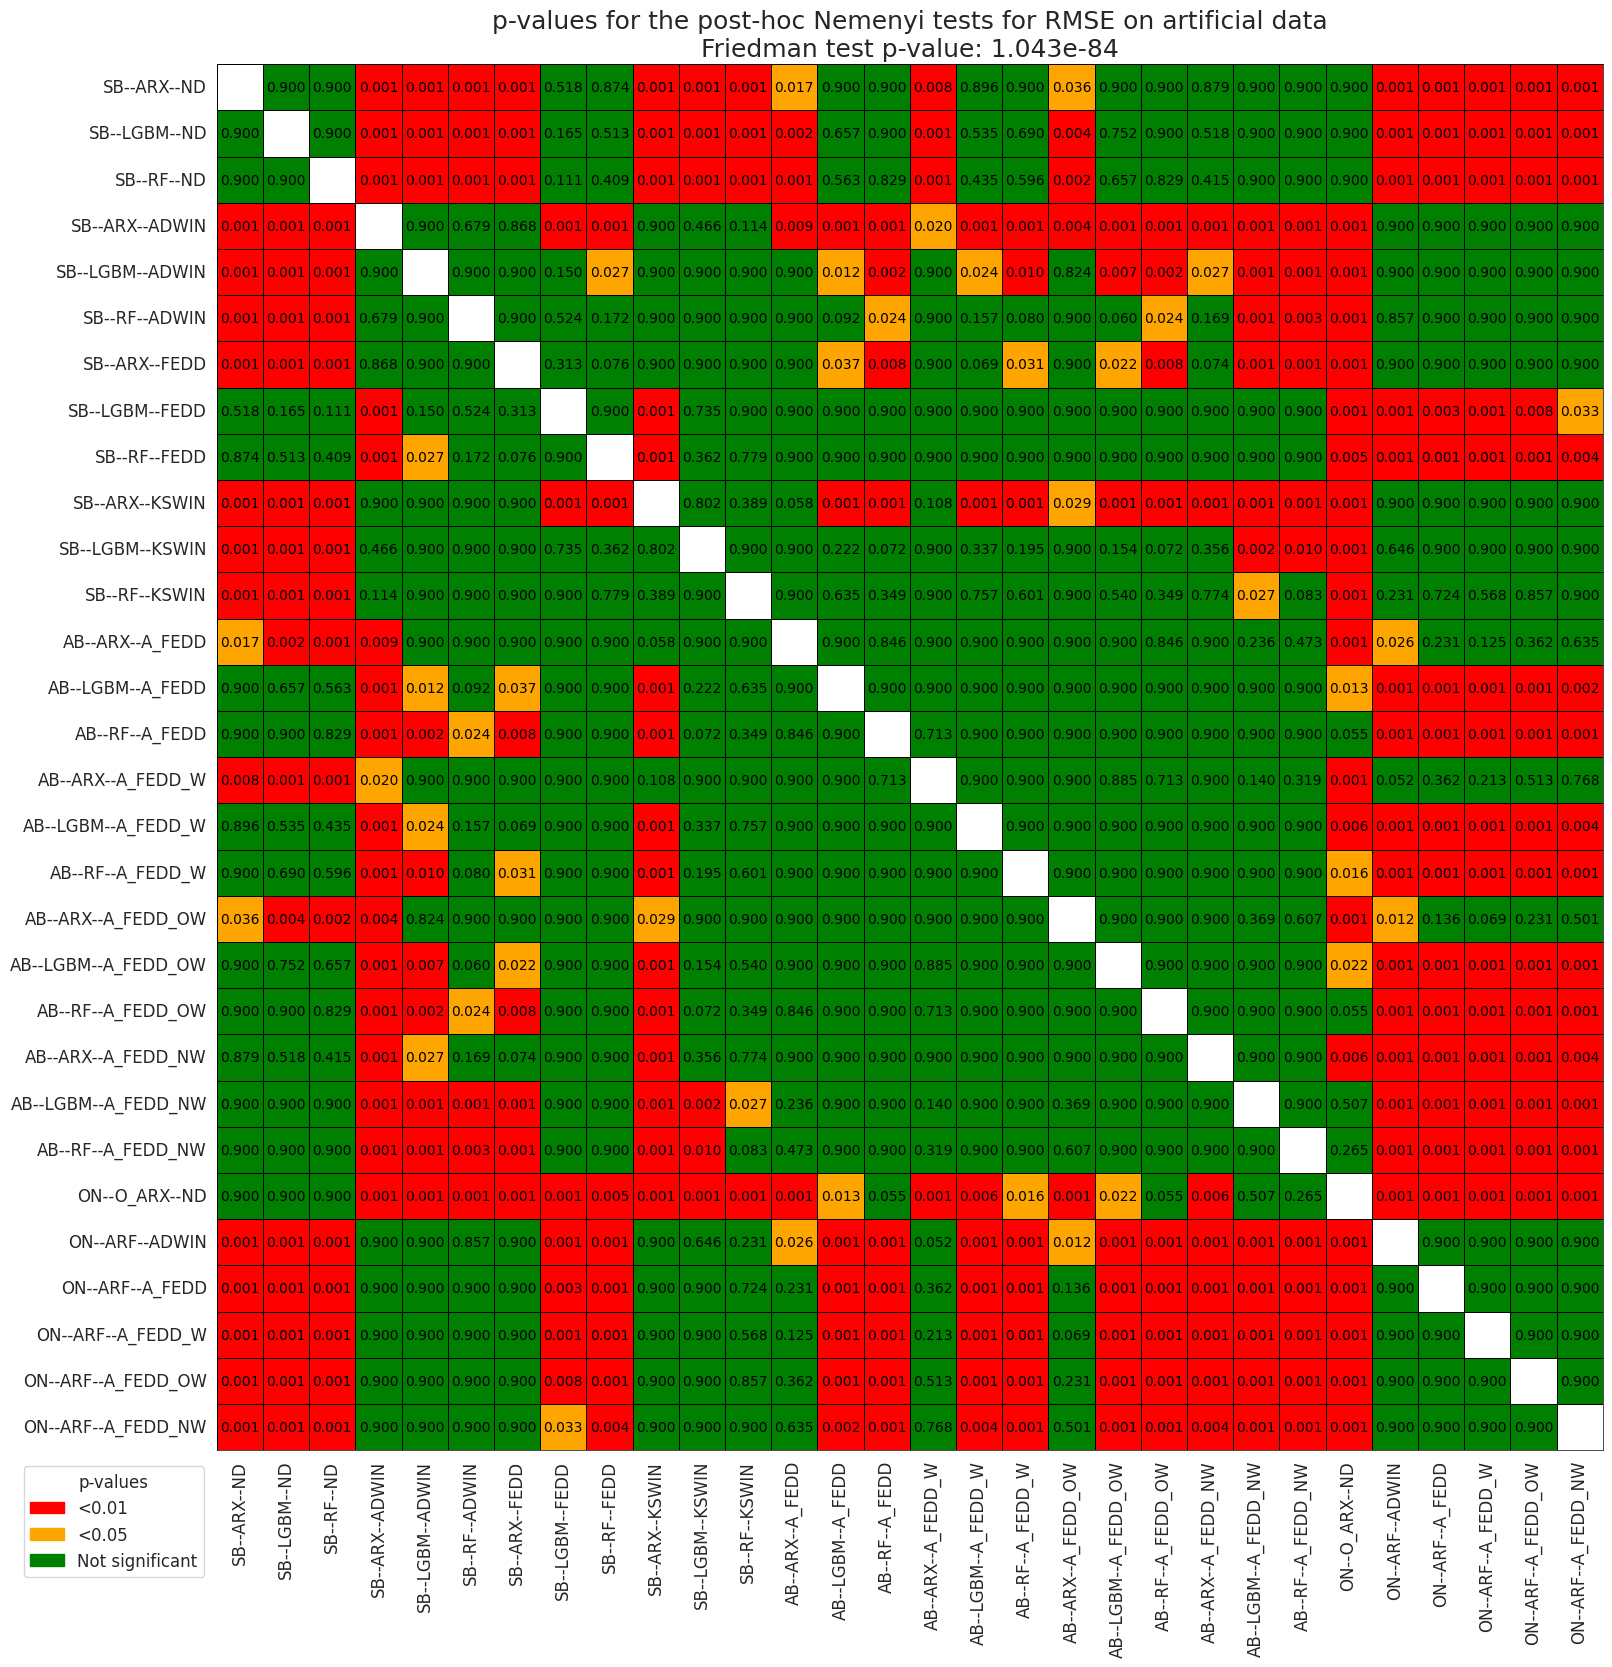

In [60]:
plt.figure(figsize=(18, 18))
plot_heatmap_with_p_values(post_hoc_results, prop={'size': 12}, title_fontsize='large', bbox_to_anchor=(0.125, 0.1057))
plt.xticks(np.arange(post_hoc_results.shape[0]) + 0.5, methods, rotation=90, fontsize=12)
plt.yticks(np.arange(post_hoc_results.shape[0]) + 0.5, methods, rotation=0, fontsize=12)
plt.title(
    'p-values for the post-hoc Nemenyi tests for RMSE on artificial data\n' +\
    f'Friedman test p-value: {friedman_result.pvalue:.3e}',
    fontsize=18
)
plt.show()

Real RMSE

In [61]:
df_stat_rmse_artificial = pd.DataFrame(rmse_per_experiment_real).iloc[:, 0:-1]
df_stat_rmse_artificial.columns = ['ts', 'method', 'rmse']

# set order
#############################
df_stat_rmse_artificial['method'] = df_stat_rmse_artificial['method'].str.split('.').str[0]
df_stat_rmse_artificial['framework'] = df_stat_rmse_artificial['method'].apply(exp_name_to_framework)
df_stat_rmse_artificial['detector'] = df_stat_rmse_artificial['method'].apply(exp_name_to_drift_detector)
df_stat_rmse_artificial['model'] = df_stat_rmse_artificial['method'].apply(exp_name_to_model)

for i in range(df_stat_rmse_artificial.shape[0]):
    if df_stat_rmse_artificial.loc[i]['framework'] == 'Online' and \
       df_stat_rmse_artificial.loc[i]['model'] == 'Adaptive Random Forest' and \
       df_stat_rmse_artificial.loc[i]['detector'] != 'ADWIN':
        df_stat_rmse_artificial.loc[i, 'framework'] = 'Modified Adaptive Random Forest'
        df_stat_rmse_artificial.loc[i, 'model'] = 'Modified Adaptive Random Forest'

df_stat_rmse_artificial['frm_rank'] = df_stat_rmse_artificial['framework'].map(ranks)
df_stat_rmse_artificial['dt_rank'] = df_stat_rmse_artificial['detector'].map(ranks_detectors)
df_stat_rmse_artificial = df_stat_rmse_artificial.sort_values(by=['ts', 'frm_rank', 'dt_rank', 'model'], ascending=[True, True, True, True]).iloc[:, :-5].reset_index(drop=True).copy()
#############################

In [62]:
df_with_order = pd.DataFrame({'org_name': df_stat_rmse_artificial[df_stat_rmse_artificial['ts'] == 'ING__MACHINE_0__cpu_used_perc']['method'].tolist()})
df_with_order = df_with_order.reset_index()
df_with_order['code'] = df_with_order['org_name'].apply(generate_key_per_stat_test)
order_of_codes = list(df_with_order['code'])

In [63]:
df_stat_rmse_artificial['method'] = df_stat_rmse_artificial['method'].apply(generate_key_per_stat_test)
df_stat_rmse_artificial = pd.pivot(df_stat_rmse_artificial, columns='method', index='ts')
df_stat_rmse_artificial.columns = df_stat_rmse_artificial.columns.droplevel(0)
df_stat_rmse_artificial = df_stat_rmse_artificial[order_of_codes]

In [64]:
methods = list(df_stat_rmse_artificial.columns)
friedman_result, post_hoc_results = run_tests(df_stat_rmse_artificial)

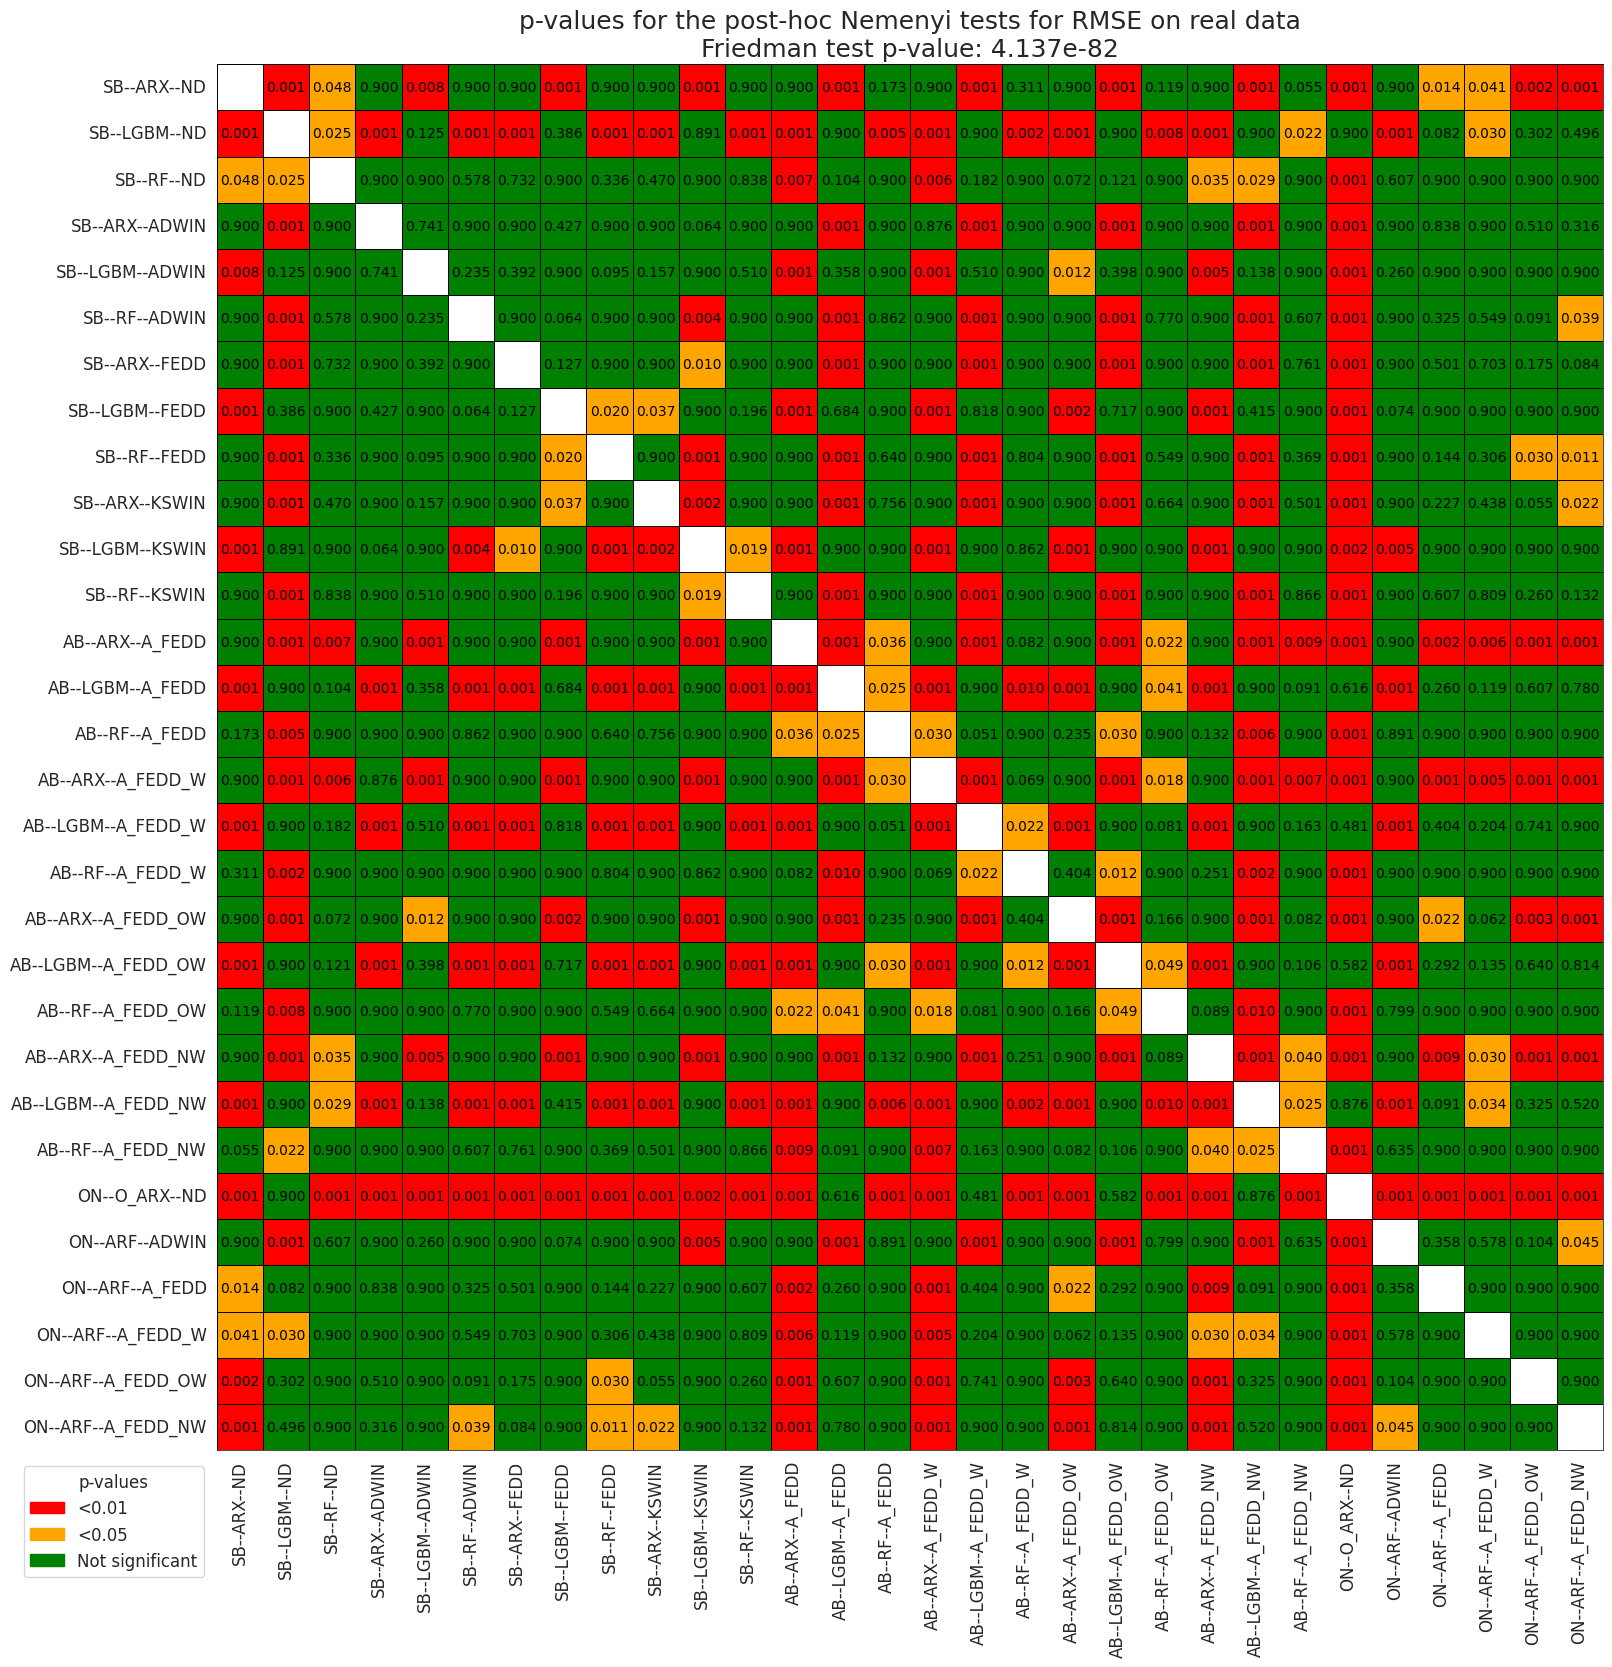

In [66]:
plt.figure(figsize=(18, 18))
plot_heatmap_with_p_values(post_hoc_results, prop={'size': 12}, title_fontsize='large', bbox_to_anchor=(0.125, 0.1057))
plt.xticks(np.arange(post_hoc_results.shape[0]) + 0.5, methods, rotation=90, fontsize=12)
plt.yticks(np.arange(post_hoc_results.shape[0]) + 0.5, methods, rotation=0, fontsize=12)
plt.title(
    'p-values for the post-hoc Nemenyi tests for RMSE on real data\n' +\
    f'Friedman test p-value: {friedman_result.pvalue:.3e}',
    fontsize=18
)
plt.show()

Artificial - number of drifts

In [67]:
def count_detections_raw(results, exp_name_agg=exp_name_to_drift_detector):
    if_replaced_buckets = {}

    for ts_name, exp_dict in results.items():
        key = ts_name

        for exp_name, exp_obj in exp_dict.items():
            if 'batch' in exp_name:
                exp_key = exp_name_agg(exp_name)
                detected = len(exp_obj['experiment_obj'].replacement_history)
        
                if (key, exp_key) in if_replaced_buckets.keys():
                    if_replaced_buckets[(key, exp_key)] += detected
                else:
                    if_replaced_buckets[(key, exp_key)] = detected
    out = []
    for key, val in if_replaced_buckets.items():
        out.append((key[0], key[1], val))
        
    out = pd.DataFrame(out)
    out.columns = ['ts', 'detector', 'n_detected']
    return out

In [68]:
df_test_detected = count_detections_raw(results_artificial)

df_test_detected = df_test_detected[df_test_detected['detector'] != '-']
df_test_detected['dt_rank'] = df_test_detected['detector'].map(ranks_detectors)
df_test_detected = df_test_detected.sort_values(by=['ts', 'dt_rank'], ascending=True).iloc[:, :-1].reset_index(drop=True).copy()
detector_order = df_test_detected[df_test_detected['ts'] == 'linear_1__10']['detector'].tolist()

In [69]:
df_test_detected = pd.pivot(df_test_detected, columns='detector', index='ts')
df_test_detected.columns = df_test_detected.columns.droplevel(0)
df_test_detected = df_test_detected[detector_order]

In [70]:
methods = list(df_test_detected.columns)
friedman_result, post_hoc_results = run_tests(df_test_detected)

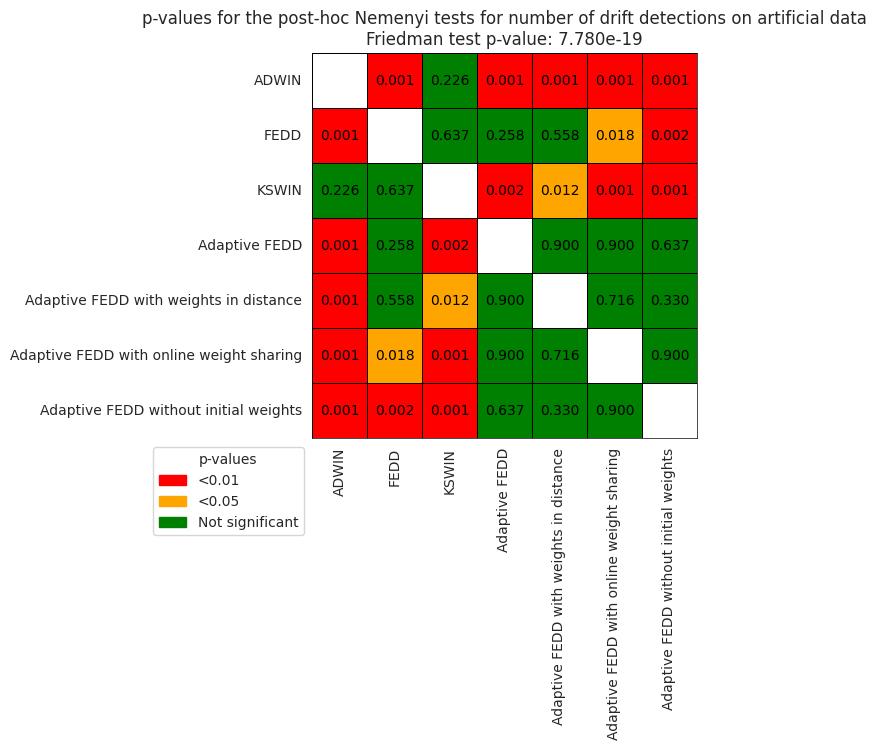

In [73]:
plt.figure(figsize=(5, 5))
plot_heatmap_with_p_values(post_hoc_results, bbox_to_anchor=(0.125, 0.1057))
plt.xticks(np.arange(post_hoc_results.shape[0]) + 0.5, methods, rotation=90)
plt.yticks(np.arange(post_hoc_results.shape[0]) + 0.5, methods, rotation=0)
plt.title(
    'p-values for the post-hoc Nemenyi tests for number of drift detections on artificial data\n' +\
    f'Friedman test p-value: {friedman_result.pvalue:.3e}'
)
plt.show()

Real - number of drifts

In [74]:
df_test_detected = count_detections_raw(results_real)

df_test_detected = df_test_detected[df_test_detected['detector'] != '-']
df_test_detected['dt_rank'] = df_test_detected['detector'].map(ranks_detectors)
df_test_detected = df_test_detected.sort_values(by=['ts', 'dt_rank'], ascending=True).iloc[:, :-1].reset_index(drop=True).copy()
detector_order = df_test_detected[df_test_detected['ts'] == 'ING__MACHINE_0__cpu_used_perc']['detector'].tolist()

In [75]:
df_test_detected = pd.pivot(df_test_detected, columns='detector', index='ts')
df_test_detected.columns = df_test_detected.columns.droplevel(0)
df_test_detected = df_test_detected[detector_order]

In [76]:
methods = list(df_test_detected.columns)
friedman_result, post_hoc_results = run_tests(df_test_detected)

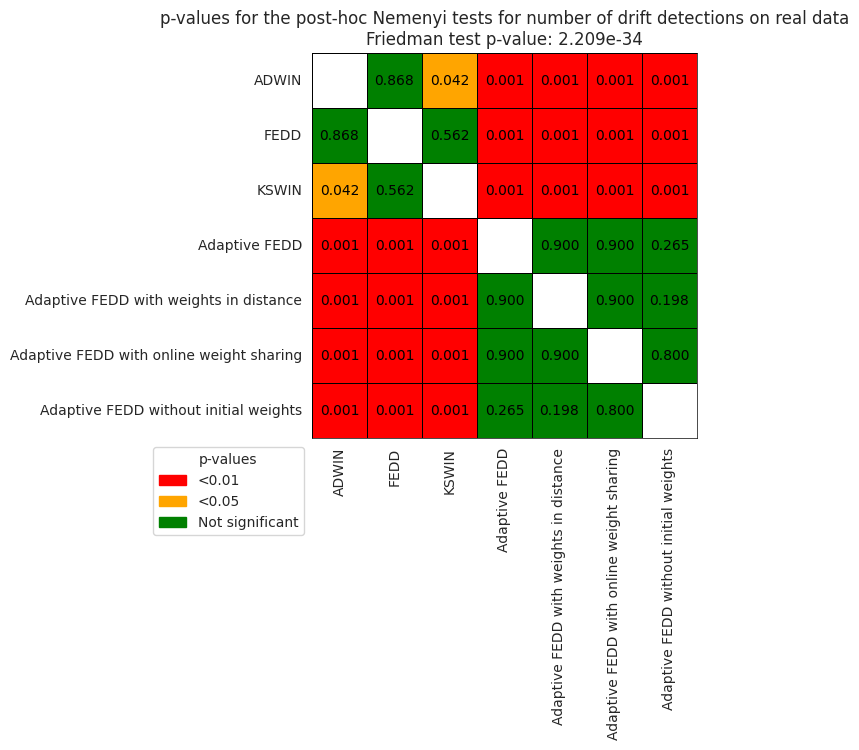

In [78]:
plt.figure(figsize=(5, 5))
plot_heatmap_with_p_values(post_hoc_results, bbox_to_anchor=(0.125, 0.1057))
plt.xticks(np.arange(post_hoc_results.shape[0]) + 0.5, methods, rotation=90)
plt.yticks(np.arange(post_hoc_results.shape[0]) + 0.5, methods, rotation=0)
plt.title(
    'p-values for the post-hoc Nemenyi tests for number of drift detections on real data\n' +\
    f'Friedman test p-value: {friedman_result.pvalue:.3e}'
)
plt.show()

### RMSE over time - example

In [79]:
from sklearn.metrics import root_mean_squared_error as rmse

In [80]:
from matplotlib.axes import Axes

def legend_without_duplicate_labels(ax: Axes):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

In [81]:
def calculate_metric_per_origin(y_true, y_hat, metric=rmse):
    out = []
    origins = np.unique(y_hat['origin'])

    for origin in origins:
        horizon = y_hat[y_hat['origin'] == origin]['timestamp'].tolist()
        y_true_horizon = y_true[y_true['timestamp'].isin(horizon)]['value'].to_numpy()
        y_hat_horizon = y_hat[y_hat['origin'] == origin]['value'].to_numpy()

        if len(y_true_horizon) < len(y_hat_horizon):
            # case at the end of the time
            continue

        val = metric(y_true_horizon, y_hat_horizon)
        out.append({
            'origin': origin,
            'metric': val
        })
        
    return pd.DataFrame(out)

In [83]:
ts_dict = results_artificial['linear_1__0']

obj = ts_dict['batch__arx__adaptive_fedd']['experiment_obj']
out = calculate_metric_per_origin(obj.data, obj.predictions)

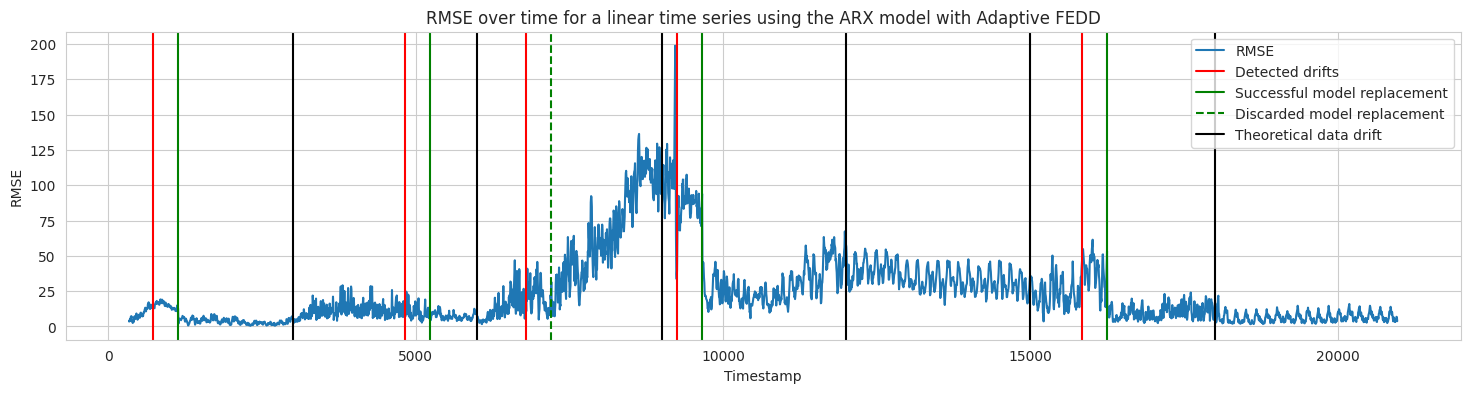

In [85]:
plt.subplots(figsize=(18, 4))
sns.lineplot(x='origin', y='metric', data=out, label='RMSE')
plt.xlabel('Timestamp')
plt.ylabel('RMSE')
plt.title('RMSE over time for a linear time series using the ARX model with Adaptive FEDD')

for t in obj.drift_history:
    plt.axvline(x=t, label='Detected drifts', color='red')

for i, t in enumerate(obj.replacement_history):
    if obj.was_replaced_history[i] == True:
        plt.axvline(x=t, label='Successful model replacement', color='green')
    else:
        plt.axvline(x=t, label='Discarded model replacement', color='green', ls='--')

for t in [3000, 6000, 9000, 12000, 15000, 18000]:
    plt.axvline(x=t, label='Theoretical data drift', color='black')

plt.legend()
legend_without_duplicate_labels(plt.gca())
plt.show()

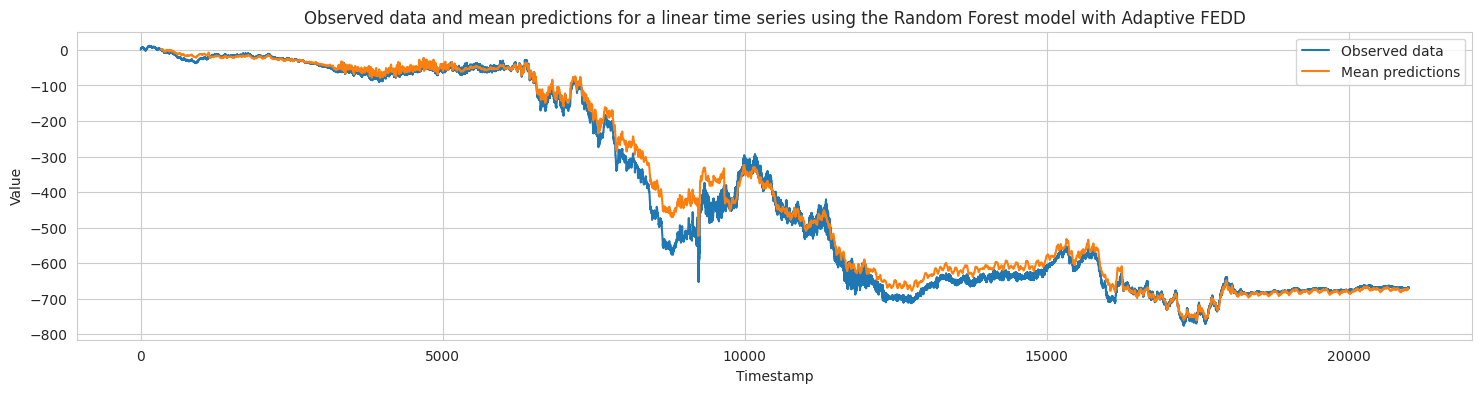

In [87]:
plt.subplots(figsize=(18, 4))
sns.lineplot(x='timestamp', y='value', data=obj.data, label='Observed data')
sns.lineplot(x='origin', y='value', data=obj.predictions.groupby('origin')['value'].mean().reset_index(), label='Mean predictions')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Observed data and mean predictions for a linear time series using the Random Forest model with Adaptive FEDD')
plt.legend()
plt.show()

In [88]:
def detector_format(dt_name):
    if dt_name == 'adaptive_fedd':
        return 'Adaptive FEDD'
    if dt_name == 'adaptive_fedd_with_weights':
        return 'Adaptive FEDD with weights in distance function'
    if dt_name == 'adwin':
        return 'ADWIN'
    if dt_name == 'fedd':
        return 'FEDD'
    if dt_name == 'kswin':
        return 'KSWIN'
    if dt_name == 'no_drift':
        return 'no drift detection'

In [89]:
arx_keys = [
    'batch__arx__adaptive_fedd',
    'batch__arx__adaptive_fedd_with_weights',
    'batch__arx__fedd',
    'batch__arx__no_drift'
]
arx_keys_labels = [detector_format(key.split('__')[-1]) for key in arx_keys]

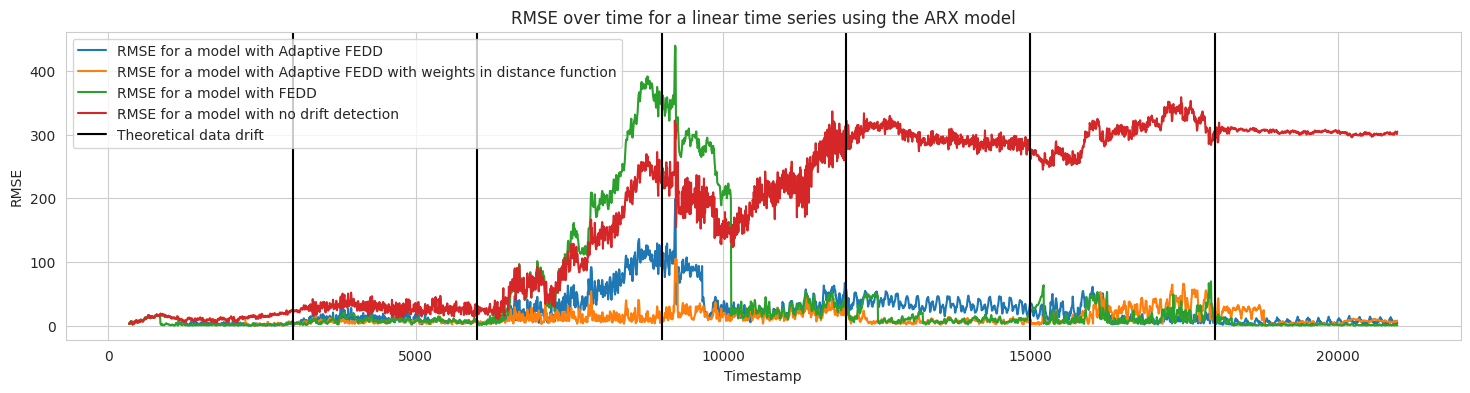

In [91]:
plt.subplots(figsize=(18, 4))

for i, key in enumerate(arx_keys):
    obj = ts_dict[key]['experiment_obj']
    out = calculate_metric_per_origin(obj.data, obj.predictions)

    sns.lineplot(x='origin', y='metric', data=out, label=f'RMSE for a model with {arx_keys_labels[i]}')

for t in [3000, 6000, 9000, 12000, 15000, 18000]:
    plt.axvline(x=t, label='Theoretical data drift', color='black')

plt.xlabel('Timestamp')
plt.ylabel('RMSE')
plt.title('RMSE over time for a linear time series using the ARX model')
plt.legend()
legend_without_duplicate_labels(plt.gca())
plt.show()

### RMSE over time example - real data

In [93]:
ts_dict = results_real['ING__MACHINE_2__memory_used_perc']

obj = ts_dict['batch__rf__adaptive_fedd_without_weight_sharing_with_weight_in_distance']['experiment_obj']
out = calculate_metric_per_origin(obj.data, obj.predictions)

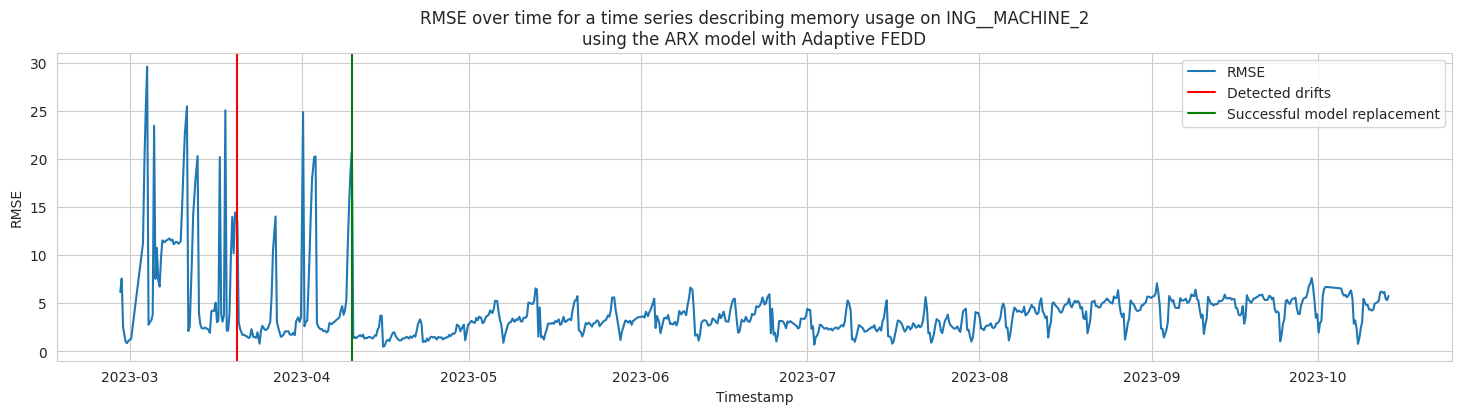

In [95]:
plt.subplots(figsize=(18, 4))
sns.lineplot(x='origin', y='metric', data=out, label='RMSE')
plt.xlabel('Timestamp')
plt.ylabel('RMSE')
plt.title('RMSE over time for a time series describing memory usage on ING__MACHINE_2\nusing the ARX model with Adaptive FEDD')

for t in obj.drift_history:
    plt.axvline(x=t, label='Detected drifts', color='red')

for i, t in enumerate(obj.replacement_history):
    if obj.was_replaced_history[i] == True:
        plt.axvline(x=t, label='Successful model replacement', color='green')
    else:
        plt.axvline(x=t, label='Discarded model replacement', color='green', ls='--')

plt.legend()
legend_without_duplicate_labels(plt.gca())
plt.show()

In [ ]:
plt.subplots(figsize=(18, 4))
sns.lineplot(x='timestamp', y='value', data=obj.data, label='Observed data')
sns.lineplot(x='origin', y='value', data=obj.predictions.groupby('origin')['value'].mean().reset_index(), label='Mean predictions')
plt.xlabel('Timestamp')
plt.ylabel('Memory usage')
plt.title('Observed data and mean predictions for a time series describing memory usage on ING__MACHINE_2\nusing the Random Forest model with Adaptive FEDD')

plt.legend()
plt.show()

In [98]:
def detector_format(dt_name):
    if dt_name == 'adaptive_fedd_without_weight_sharing':
        return 'Adaptive FEDD'
    if dt_name == 'adaptive_fedd_without_weight_sharing_with_weight_in_distance':
        return 'Adaptive FEDD with weights in distance function'
    if dt_name == 'adwin':
        return 'ADWIN'
    if dt_name == 'fedd':
        return 'FEDD'
    if dt_name == 'kswin':
        return 'KSWIN'
    if dt_name == 'no_drift':
        return 'no drift detection'

In [99]:
arx_keys = [
    'batch__arx__adaptive_fedd_without_weight_sharing',
    'batch__arx__adaptive_fedd_without_weight_sharing_with_weight_in_distance',
    'batch__arx__fedd',
    'batch__arx__no_drift'
]
arx_keys_labels = [detector_format(key.split('__')[-1]) for key in arx_keys]

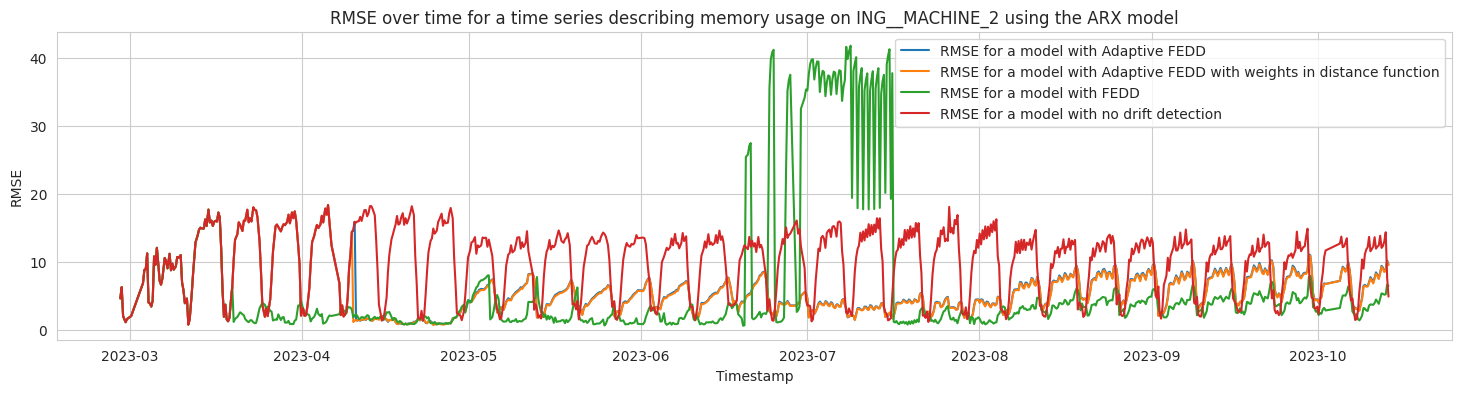

In [101]:
plt.subplots(figsize=(18, 4))

for i, key in enumerate(arx_keys):
    obj = ts_dict[key]['experiment_obj']
    out = calculate_metric_per_origin(obj.data, obj.predictions)

    sns.lineplot(x='origin', y='metric', data=out, label=f'RMSE for a model with {arx_keys_labels[i]}')

plt.xlabel('Timestamp')
plt.ylabel('RMSE')
plt.title('RMSE over time for a time series describing memory usage on ING__MACHINE_2 using the ARX model')
plt.legend()
legend_without_duplicate_labels(plt.gca())
plt.show()

### Appendix

In [102]:
# how much missing data in real data?

In [103]:
import os
import pandas as pd
import numpy as np

In [104]:
def find_csv_files(path):
    files = os.listdir(path)
    files = [filename for filename in files if filename.endswith('.csv')]
    files = [os.path.join(path, file) for file in files]
    return files

artificial_ts_files = find_csv_files('../data/raw/ING')

In [105]:
res = {}

for time_series_path in artificial_ts_files:
    data = pd.read_csv(time_series_path, index_col=0)
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data = data.sort_values(by='timestamp')

    full_range = pd.date_range(start=data['timestamp'].min(), end=data['timestamp'].max(), freq='h')
    missing = len(full_range.difference(data['timestamp']))

    data['diff'] = data['timestamp'].diff()
    missing_larger_than_2_hours = data[data['diff'] >= pd.Timedelta(hours=2)].shape[0]

    res[os.path.basename(time_series_path)] = {
        'observed': data.shape[0], 'missing': missing, 'expected': len(full_range),
        'missing_larger_than_2_hours': missing_larger_than_2_hours
        }

In [106]:
count = pd.DataFrame.from_dict(res, orient='index')
count['missing_perc'] = count['missing'] / count['expected']
count['missing_perc_more_than_one'] = count['missing_larger_than_2_hours'] / count['expected']
count = count.reset_index()
count = count[['index', 'missing_perc', 'missing_perc_more_than_one']]
# format 3 digits after comma
count[['missing_perc', 'missing_perc_more_than_one']] = count[['missing_perc', 'missing_perc_more_than_one']].apply(lambda x: round(x * 100, 2)) 
count['missing'] = count['missing_perc'].astype(str) + ' / ' + count['missing_perc_more_than_one'].astype(str)
count['metric'] = count['index'].apply(lambda x: 'memory' if 'memory' in x else 'cpu')
count['machine'] = count['index'].apply(lambda x: 'ING__' + x.split('__')[1])
count = count[['machine', 'metric', 'missing']]
count = pd.pivot(count, index=['machine'], columns='metric').reset_index()
count.columns = count.columns.droplevel(0)
count.columns.name = None
cols = list(count.columns)
cols[0] = 'Machine'
count.columns = cols
count['for_sorting'] = count['Machine'].apply(lambda x: int(x.split('__')[1].split('_')[-1]))
count = count.sort_values(by='for_sorting').iloc[:, :-1].reset_index(drop=True).copy()

count

,Machine,cpu,memory
0,ING__MACHINE_0,9.04 / 1.99,9.04 / 1.99
1,ING__MACHINE_1,9.04 / 1.99,9.04 / 1.99
2,ING__MACHINE_2,9.04 / 1.99,9.04 / 1.99
3,ING__MACHINE_3,9.04 / 1.99,9.04 / 1.99
4,ING__MACHINE_4,9.2 / 1.86,9.2 / 1.87
5,ING__MACHINE_5,9.04 / 1.99,9.04 / 1.99
6,ING__MACHINE_6,9.04 / 1.99,9.04 / 1.99
7,ING__MACHINE_7,9.04 / 1.99,9.04 / 1.99
8,ING__MACHINE_8,10.26 / 2.34,10.29 / 2.36
9,ING__MACHINE_9,10.27 / 2.36,10.24 / 2.34
